# Setting up

In [ ]:
!pip install tensorflow-recommenders --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow==2.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: keras
    Found existing installation: ke

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import glob
import numpy as np
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
from typing import Dict, Text
import datetime as dt
import pickle
import random

print(tfrs.__version__)
print(tf.__version__)

v0.7.3
2.11.0


# Data

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/Work/C4R/Metro/Data/ml_300.csv')

result.shape

(8096818, 12)

In [ ]:
print(result['city'].unique())

['KYIV' 'ODESA' 'KHARKIV' 'DNIPROPETROVSK' 'LVIV' 'ZAPORIZHZHYA'
 'KRYVYY RIH' 'VINNYTSYA' 'MYKOLAIV' 'POLTAVA' 'IVANO-FRANKIVSK'
 'CHERNIVTSI' 'RIVNE' 'ZHYTOMYR' 'LUTSK' 'TERNOPIL' 'CHERNIGIV']


In [ ]:
# result = result.loc[(result['city'] == 'KYIV')]

result[['cust_person_id', 'product_id']] = result[['cust_person_id', 'product_id']].astype(str)
result[['visits', 'sell_total_val_nsp', 'sell_val_nsp']] = result[['visits', 'sell_total_val_nsp', 'sell_val_nsp']].fillna(0)
result[['visits', 'sell_total_val_nsp', 'sell_val_nsp']] = result[['visits', 'sell_total_val_nsp', 'sell_val_nsp']].astype(int)
result[['SEGMENT_GROUP']] = result[['SEGMENT_GROUP']].fillna('unknown')

print(result.shape)
result.tail()

(8096818, 12)


,Unnamed: 0,store_id,cust_person_id,product_id,sell_val_nsp,SEGMENT_GROUP,visits,sell_total_val_nsp,city,art_name_tl,pcg_cat_desc_tl,pcg_sub_cat_desc_tl
8096813,9475995,67,670100000315,384191001001,62,Core (benchmark),13,29762,CHERNIGIV,MC SALTED ATLANTIC HERRING FILLETS WITH HERBS ...,HERRINGS,IN BRINE
8096814,9475996,67,870100000315,318757001001,91,Convenience shopper small basket,9,10545,CHERNIGIV,ARO OILFISH COLD CMOKED 180 G,OTHER FISH TYPES,OTHER FISH TYPES
8096815,9475997,67,870100000315,327947001001,166,Convenience shopper small basket,9,10545,CHERNIGIV,SLICED SERRANO HAM 100GR - INERT GAS TRAY,SPANISH RAW HAM,IBERICO SLICED
8096816,9475998,67,870100000315,377016001001,333,Convenience shopper small basket,9,10545,CHERNIGIV,"BEER LVIVSKE SVITLE , CAN 0.48L",PILSNER,CAN 0 - 50 cl
8096817,9475999,67,870100000315,400556001001,66,Convenience shopper small basket,9,10545,CHERNIGIV,ARO SALMON SMOKED 130G,NORWEGEAN SALMON,CRUMBS/CHUNKS


In [ ]:
result['pcg_cat_desc_tl'].nunique()


516

In [ ]:
result.dtypes

,0
Unnamed: 0,int64
store_id,int64
cust_person_id,object
product_id,object
sell_val_nsp,int64
SEGMENT_GROUP,object
visits,int64
sell_total_val_nsp,int64
city,object
art_name_tl,object


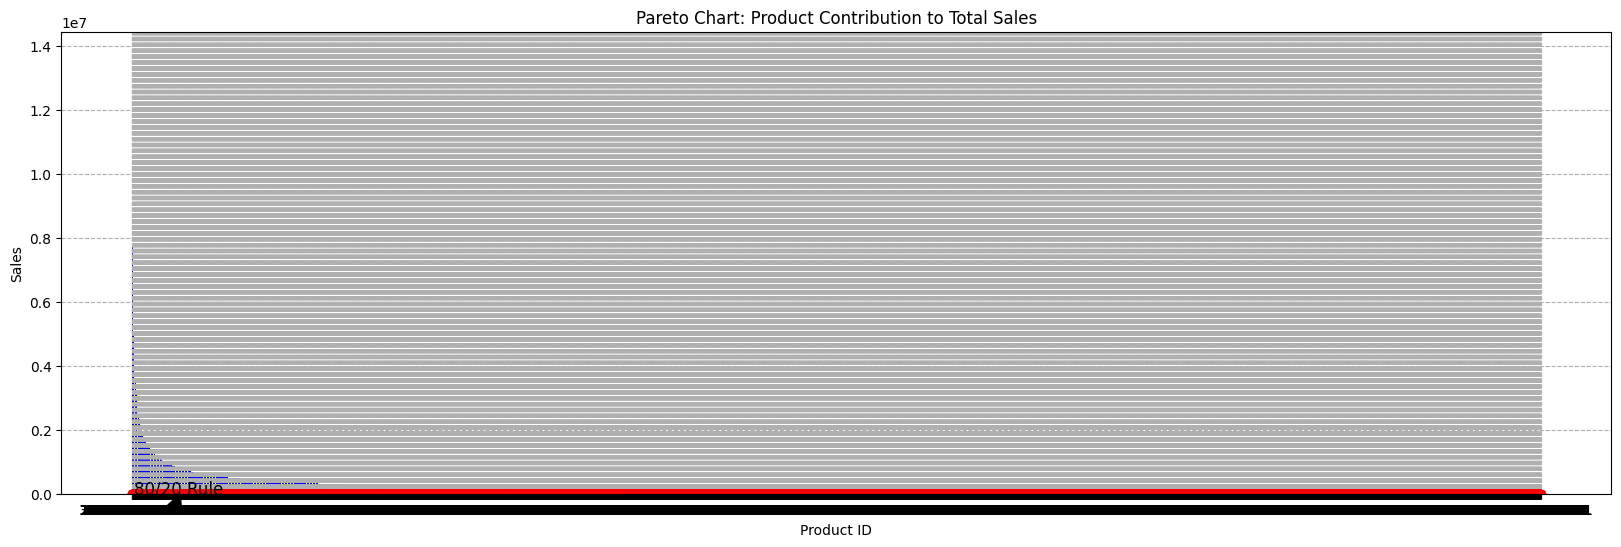

In [ ]:
product_df = result.groupby('product_id')['sell_val_nsp'].sum().reset_index()

product_df = product_df.sort_values(by='sell_val_nsp', ascending=False)

# Calculate the cumulative percentage of sales
product_df['cumulative_percentage'] = (product_df['sell_val_nsp'].cumsum() / product_df['sell_val_nsp'].sum()) * 100

# Create the Pareto chart
plt.figure(figsize=(20, 6))
plt.bar(product_df['product_id'], product_df['sell_val_nsp'], color='blue')
plt.plot(product_df['product_id'], product_df['cumulative_percentage'], color='red', marker='o')

# Add labels and title
plt.xlabel('Product ID')
plt.ylabel('Sales')
plt.title('Pareto Chart: Product Contribution to Total Sales')

# Grid and annotations
plt.grid(True, linestyle='--')
plt.annotate('80/20 Rule', xy=(product_df['product_id'][1], product_df['cumulative_percentage'][1]), xytext=(10, 10),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

plt.show()

In [ ]:
temp_df = product_df[(product_df['cumulative_percentage'] <= 100)]

print(temp_df.shape, product_df.shape)
print(temp_df['product_id'].nunique(), product_df['product_id'].nunique())

(6594, 3) (6594, 3)
6594 6594


In [ ]:
temp_df.tail()

,product_id,sell_val_nsp,cumulative_percentage
5860,385840001001,3384,99.999389
3904,363761001001,2709,99.999606
3902,363759001001,2268,99.999789
5859,385838001001,1681,99.999924
3903,363760001001,951,100.000000


In [ ]:
product_list = list(set(temp_df['product_id'].to_list()))

print(len(product_list))

6594


In [ ]:
filtered_df = result[result['product_id'].isin(product_list)]

print(filtered_df.shape, result.shape)

(8096818, 12) (8096818, 12)


In [ ]:
filtered_df['product_id'].nunique()

6594

In [ ]:
filtered_df.tail()

,Unnamed: 0,store_id,cust_person_id,product_id,sell_val_nsp,SEGMENT_GROUP,visits,sell_total_val_nsp,city,art_name_tl,pcg_cat_desc_tl,pcg_sub_cat_desc_tl
8096813,9475995,67,670100000315,384191001001,62,Core (benchmark),13,29762,CHERNIGIV,MC SALTED ATLANTIC HERRING FILLETS WITH HERBS ...,HERRINGS,IN BRINE
8096814,9475996,67,870100000315,318757001001,91,Convenience shopper small basket,9,10545,CHERNIGIV,ARO OILFISH COLD CMOKED 180 G,OTHER FISH TYPES,OTHER FISH TYPES
8096815,9475997,67,870100000315,327947001001,166,Convenience shopper small basket,9,10545,CHERNIGIV,SLICED SERRANO HAM 100GR - INERT GAS TRAY,SPANISH RAW HAM,IBERICO SLICED
8096816,9475998,67,870100000315,377016001001,333,Convenience shopper small basket,9,10545,CHERNIGIV,"BEER LVIVSKE SVITLE , CAN 0.48L",PILSNER,CAN 0 - 50 cl
8096817,9475999,67,870100000315,400556001001,66,Convenience shopper small basket,9,10545,CHERNIGIV,ARO SALMON SMOKED 130G,NORWEGEAN SALMON,CRUMBS/CHUNKS


In [ ]:
filtered_df['pcg_cat_desc_tl'].nunique()


516

# TF records

In [ ]:
def save_to_tf_records(df, output_dir, rows_per_file=1000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in range(0, len(df), rows_per_file):
        chunk = df[i:i+rows_per_file]
        filename = f"data_{i:05d}.tfrecord"
        filepath = os.path.join(output_dir, filename)
        with tf.io.TFRecordWriter(filepath) as writer:
            for _, row in chunk.iterrows():
                example = tf.train.Example(features=tf.train.Features(feature={
                    'customer_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row["cust_person_id"].encode()])),
                    'product_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row["product_id"].encode()])),
                    # 'segment': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row["SEGMENT_GROUP"].encode()])),
                    # "visits": tf.train.Feature(int64_list=tf.train.Int64List(value=[row["visits"]])),
                    "revenue": tf.train.Feature(int64_list=tf.train.Int64List(value=[row["sell_total_val_nsp"]])),
                    'city': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row["city"].encode()])),
                    # 'articul': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row["art_name_tl"].encode()])),
                    # 'category': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row["pcg_cat_desc_tl"].encode()])),
                    # 'sub_category': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row["pcg_sub_cat_desc_tl"].encode()])),
                    # "ts": tf.train.Feature(int64_list=tf.train.Int64List(value=[row["ts"]])),
                    # 'rating': tf.train.Feature(int64_list=tf.train.Int64List(value=[row["sell_val_nsp"]])),
                    }))

                writer.write(example.SerializeToString())



In [ ]:
save_to_tf_records(filtered_df, "tf_recs", rows_per_file=200_000)


# TF Dataset

In [ ]:
feature_description = {
    'product_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'customer_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    # 'segment': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'city': tf.io.FixedLenFeature([], tf.string, default_value=''),
    # 'articul': tf.io.FixedLenFeature([], tf.string, default_value=''),
    # 'category': tf.io.FixedLenFeature([], tf.string, default_value=''),
    # 'sub_category': tf.io.FixedLenFeature([], tf.string, default_value=''),
    # 'visits': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'revenue': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    # 'ts': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    # 'rating': tf.io.FixedLenFeature([], tf.int64, default_value=0),
 }

def _parse_function(example_proto):
  return tf.io.parse_single_example(example_proto, feature_description)


In [ ]:
tfrecord_files = glob.glob('tf_recs/*')

full_ds = tf.data.TFRecordDataset(tfrecord_files).map(_parse_function)

for elem in full_ds.take(1):
    print(elem)


{'city': <tf.Tensor: shape=(), dtype=string, numpy=b'VINNYTSYA'>, 'customer_id': <tf.Tensor: shape=(), dtype=string, numpy=b'270060668601'>, 'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'387912001001'>, 'revenue': <tf.Tensor: shape=(), dtype=int64, numpy=19178>}


In [ ]:
client_ds = full_ds.map(lambda x: {
    "product_id": x["product_id"],
    'customer_id': x['customer_id'],
    # "segment": x['segment'],
    'city': x['city'],
    # 'visits': x['visits'],
    'revenue': x['revenue'],
    # 'category': x['category'],
    # 'sub_category': x['sub_category'],
    # 'articul': x['articul'],
    # 'ts': x['ts'],
    # 'rating': x['rating'],
})

for elem in client_ds.take(2):
    print(elem)

unique_product_ids_df = pd.DataFrame(filtered_df['product_id'].unique(), columns=['product_id'])

product_ids = {key: col.values for key, col in dict(unique_product_ids_df[['product_id']]).items()}

product_ds = tf.data.Dataset.from_tensor_slices(product_ids)

for elem in product_ds.take(2):
    print(elem)



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


{'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'387912001001'>, 'customer_id': <tf.Tensor: shape=(), dtype=string, numpy=b'270060668601'>, 'city': <tf.Tensor: shape=(), dtype=string, numpy=b'VINNYTSYA'>, 'revenue': <tf.Tensor: shape=(), dtype=int64, numpy=19178>}
{'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'390458001001'>, 'customer_id': <tf.Tensor: shape=(), dtype=string, numpy=b'270060668601'>, 'city': <tf.Tensor: shape=(), dtype=string, numpy=b'VINNYTSYA'>, 'revenue': <tf.Tensor: shape=(), dtype=int64, numpy=19178>}
{'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'6754001001'>}
{'product_id': <tf.Tensor: shape=(), dtype=string, numpy=b'148975001001'>}


# Models Retrival

## Vocabs

In [ ]:
revenues = np.concatenate(list(client_ds.map(lambda x: x["revenue"]).batch(1_000)))
max_revenues = revenues.max()
min_revenues = revenues.min()

revenues_buckets = np.linspace(
    min_revenues, max_revenues, num=100,
)
unique_revenues = np.unique(np.concatenate(list(client_ds.batch(1_000).map(
                                                  lambda x: x['revenue']))))

print(len(unique_revenues))
print(unique_revenues[:10])


92869
[ 0  1  4  6  7  8  9 10 11 12]


In [ ]:
unique_product_ids = np.unique(np.concatenate(list(product_ds.batch(1_000).map(
    lambda x: x["product_id"]))))

print(len(unique_product_ids))
print(unique_product_ids[:10])


6594
[b'100007001001' b'100101001001' b'10021001003' b'10025001003'
 b'100301001001' b'100360001001' b'100683001001' b'100803001001'
 b'100897001001' b'101114001003']


In [ ]:
unique_customer_id = np.unique(np.concatenate(list(client_ds.batch(1_000).map(
    lambda x: x["customer_id"]))))

print(len(unique_customer_id))
print(unique_customer_id[:10])


398702
[b'100000002701' b'100000003802' b'100000004301' b'100000005401'
 b'100000008201' b'100000009201' b'100000013101' b'100000016103'
 b'100000018101' b'100000019304']


In [ ]:
unique_city = np.unique(np.concatenate(list(client_ds.batch(1_000).map(
    lambda x: x["city"]))))

print(len(unique_city))
print(unique_city)


17
[b'CHERNIGIV' b'CHERNIVTSI' b'DNIPROPETROVSK' b'IVANO-FRANKIVSK'
 b'KHARKIV' b'KRYVYY RIH' b'KYIV' b'LUTSK' b'LVIV' b'MYKOLAIV' b'ODESA'
 b'POLTAVA' b'RIVNE' b'TERNOPIL' b'VINNYTSYA' b'ZAPORIZHZHYA' b'ZHYTOMYR']


In [ ]:
# unique_category = np.unique(np.concatenate(list(client_ds.batch(1_000).map(
#      lambda x: x["category"]))))

# print(len(unique_category))
# print(unique_category[:10])


516
[b'0 - 20 Liter' b'100% DIRECT/NOT FROM CONCENTRA'
 b'100% FROM CONCENTRATE' b'101 Liter and more' b'21 -50 Liter'
 b'26X26 - 39X39' b'51 - 100 Liter' b'ACCESSORIES' b'AFTER WASH AIDS'
 b'AIR FRESHNER']


## Buyer Model

In [ ]:
class BuyerModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.customers_embedding = tf.keras.Sequential([
       tf.keras.layers.StringLookup(
         vocabulary = unique_customer_id, mask_token = None),
         tf.keras.layers.Embedding(len(unique_customer_id) + 1, 32),
     ])

    self.city_embedding = tf.keras.Sequential([
       tf.keras.layers.StringLookup(
         vocabulary = unique_city, mask_token = None),
         tf.keras.layers.Embedding(len(unique_city) + 1, 32),
     ])

    # self.category_embedding = tf.keras.Sequential([
    #    tf.keras.layers.StringLookup(
    #      vocabulary = unique_category, mask_token = None),
    #      tf.keras.layers.Embedding(len(unique_category) + 1, 32),
    #  ])

    self.revenues_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(revenues_buckets.tolist()),
          tf.keras.layers.Embedding(len(revenues_buckets) + 1, 32),])
    self.normalized_revenues = tf.keras.layers.Normalization(axis=None)
    self.normalized_revenues.adapt(unique_revenues)

    # self.visits_embedding = tf.keras.Sequential([
    #       tf.keras.layers.Discretization(visits_buckets.tolist()),
    #       tf.keras.layers.Embedding(len(visits_buckets) + 1, 32),])
    # self.normalized_visits = tf.keras.layers.Normalization(axis=None)
    # self.normalized_visits.adapt(unique_visits)

  def call(self, inputs):
    return tf.concat([
      self.customers_embedding(inputs['customer_id']),
      self.city_embedding(inputs['city']),
      # self.category_embedding(inputs['category']),
      self.revenues_embedding(inputs["revenue"]),
      tf.reshape(self.normalized_revenues(inputs["revenue"]), (-1, 1)),
      # self.visits_embedding(inputs["visits"]),
      # tf.reshape(self.normalized_visits(inputs["visits"]), (-1, 1)),
      ], axis=1)


In [ ]:
buyer_model = BuyerModel()

for row in client_ds.batch(1).take(1):
  print(f"Computed representations: {buyer_model(row)[0, :]}")


Computed representations: [ 0.03399992  0.00110865 -0.03796568 -0.01992252 -0.03427275  0.02681056
  0.03629755  0.0407009   0.04813272 -0.00070733 -0.04917831  0.04750422
  0.04373807 -0.04707867  0.04597748  0.01441438 -0.01457058  0.03726821
 -0.04492712 -0.04017244 -0.02072992  0.0338434   0.02787507  0.02433487
 -0.02825066 -0.01539145 -0.03985052  0.0473851   0.03372028  0.00694267
 -0.03433452  0.02081113  0.02437956 -0.0098361  -0.02063779  0.04325503
  0.01075319  0.03511808 -0.04720321 -0.02679389 -0.02655318  0.03394173
 -0.03482348 -0.00633508 -0.01433895  0.00040828  0.00435475 -0.04551322
  0.00514252 -0.02720505  0.0031571  -0.00956987  0.02797321  0.01806644
 -0.04338205 -0.01140375  0.02951232 -0.03776421  0.04086323 -0.01744969
  0.00265629 -0.02017059 -0.03114309 -0.03447064  0.00705938 -0.02785559
  0.00362926 -0.01443974 -0.00762919 -0.01161978 -0.03665172  0.01005252
  0.02818414  0.02950962  0.04338664  0.01723618  0.04289265 -0.02741591
 -0.03608148  0.01545065 

## Product model

In [ ]:
class ProductModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.product_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_product_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_product_ids) + 1, 32),
    ])

  def call(self, inputs):
    return tf.concat([
      self.product_embedding(inputs['product_id'])
      ], axis=1)


In [ ]:
product_model = ProductModel()

for row in product_ds.batch(10).take(1):
    # print(row)
  print(f"Computed representations: {product_model(row)[0, :]}")


Computed representations: [-0.02025359 -0.03857349  0.01682725  0.04775253 -0.01636417 -0.03622451
 -0.02582481  0.04071114 -0.04165679  0.02789077 -0.02002802 -0.03647708
  0.01988009 -0.02349278 -0.00788284  0.04131683 -0.04863368 -0.03462045
 -0.00495042  0.01818936 -0.04018364 -0.02518502 -0.00601222  0.02773193
  0.00485034  0.04800156  0.03979185  0.04303421 -0.03284514 -0.02943776
 -0.01672145  0.01129471]


## Joint Model

In [ ]:
class Retrival(tfrs.models.Model):

  def __init__(self):
    super().__init__()

    self.query_model = tf.keras.Sequential([
      BuyerModel(),
      tf.keras.layers.Dense(64, kernel_regularizer= tf.keras.regularizers.l1(0.01)),
      tf.keras.layers.Dense(32),
      tf.keras.layers.Dense(16),
      # tf.keras.layers.Dense(8)
       ])

    self.candidate_model = tf.keras.Sequential([
      ProductModel(),
      tf.keras.layers.Dense(64, kernel_regularizer= tf.keras.regularizers.l1(0.01)),
      tf.keras.layers.Dense(32),
      tf.keras.layers.Dense(16),
      # tf.keras.layers.Dense(8)
      ])

    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=product_ds.batch(128).map(self.candidate_model)
        )
    )

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    buyer_embeddings = self.query_model({
      'customer_id': features['customer_id'],
      # 'category': features['category'],
      'city': features['city'],
      'revenue': features['revenue'],
      # 'visits': features['visits'],
      })

    product_embeddings = self.candidate_model({'product_id': features["product_id"]})

    return buyer_embeddings, product_embeddings


  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    buyer_embeddings, product_embeddings = self(features)

    retrieval_loss = self.retrieval_task(buyer_embeddings, product_embeddings)

    return retrieval_loss


In [ ]:
model_retrival = Retrival()


In [ ]:
iterator = client_ds.shuffle(buffer_size=1_000).take(1).as_numpy_iterator()

# Iterate over the elements and extract values
for elem in iterator:
    buyer_info = {
        'customer_id': np.array([elem['customer_id']]),
        'city': np.array([elem['city']]),
        # 'category': np.array([elem['category']]),
        'revenue': np.array([elem['revenue']]),
    }

print(model_retrival.query_model(buyer_info))

iterator = product_ds.shuffle(buffer_size=1_000).take(1).as_numpy_iterator()
for elem in iterator:
    product_detail = {
        'product_id': np.array([elem['product_id']])
    }

print(model_retrival.candidate_model(product_detail))


tf.Tensor(
[[-0.05389957  0.0216173  -0.00727413 -0.03530112 -0.01078787 -0.0249387
  -0.0061572  -0.01682053  0.00278561  0.00174664  0.01118086 -0.06660222
   0.04037008 -0.06332009  0.00439649 -0.04749972]], shape=(1, 16), dtype=float32)
tf.Tensor(
[[ 0.0205304  -0.00781439 -0.03741527 -0.03862851  0.07053401  0.04537986
  -0.00839401  0.0301592  -0.05033614  0.06038266  0.00488784 -0.00071433
   0.03028041  0.01496522 -0.01023044 -0.02649099]], shape=(1, 16), dtype=float32)


## Training

In [ ]:
tf.random.set_seed(158)
shuffled = client_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(7_500_000)
test = shuffled.skip(7_500_000)

cached_train = train.batch(10_000).cache()
cached_test = test.batch(5_000).cache()


In [ ]:
MAX_EPOCHS = 50

def compile_and_fit(model, train_ds, test_ds, patience=3):
   #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='factorized_top_k/top_5_categorical_accuracy',
  #                                                   patience=patience,
  #                                                   mode='min')

  log_dir = "/content/drive/MyDrive/Work/C4R/Metro/logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
  # log_dir = "" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  model.compile(optimizer= tf.keras.optimizers.Adagrad(0.1))

  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      callbacks = [tensorboard_callback])
  metrics = model.evaluate(test_ds, return_dict=True)

  return model, history, metrics


Epoch 1/50


750/750 [==============================] - 1040s 1s/step - factorized_top_k/top_1_categorical_accuracy: 8.8800e-05 - factorized_top_k/top_5_categorical_accuracy: 7.7867e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0018 - factorized_top_k/top_50_categorical_accuracy: 0.0110 - factorized_top_k/top_100_categorical_accuracy: 0.0234 - loss: 125176.8506 - regularization_loss: 11.2213 - total_loss: 125188.0722
Epoch 2/50
750/750 [==============================] - 985s 1s/step - factorized_top_k/top_1_categorical_accuracy: 2.8853e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0055 - factorized_top_k/top_50_categorical_accuracy: 0.0255 - factorized_top_k/top_100_categorical_accuracy: 0.0476 - loss: 90249.2319 - regularization_loss: 11.2030 - total_loss: 90260.4346
Epoch 3/50
750/750 [==============================] - 985s 1s/step - factorized_top_k/top_1_categorical_accuracy: 5.5080e-04 - factorized_top_k/top_5_categorical_ac

120/120 [==============================] - 177s 644ms/step - factorized_top_k/top_1_categorical_accuracy: 3.6024e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0030 - factorized_top_k/top_10_categorical_accuracy: 0.0061 - factorized_top_k/top_50_categorical_accuracy: 0.0261 - factorized_top_k/top_100_categorical_accuracy: 0.0474 - loss: 44091.1479 - regularization_loss: 11.9429 - total_loss: 44103.0893


Cause: could not parse the source code of <function <lambda> at 0x79b0ac78db40>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x79b0ac78db40>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[[[b'388360001001' 14.498955726623535]
  [b'388374001001' 14.474204063415527]
  [b'388362001001' 14.383733749389648]
  [b'388364001001' 14.372269630432129]
  [b'388356001001' 14.313959121704102]
  [b'388376001001' 14.30184555053711]
  [b'388366001001' 14.296295166015625]
  [b'388358001001' 14.255276679992676]
  [b'272990001001' 14.172974586486816]
  [b'388379001001' 14.169378280639648]
  [b'384892001001' 14.082386016845703]
  [b'385107001001' 14.076000213623047]
  [b'388370001001' 14.07153034210205]
  [b'189246001001' 14.024245262145996]
  [b'374427001001' 14.017303466796875]
  [b'385493001001' 13.974655151367188]
  [b'384894001001' 13.965160369873047]
  [b'377987001001' 13.937077522277832]
  [b'384893001001' 13.915267944335938]
  [b'385188001001' 13.902463912963867]
  [b'383252001001' 13.851255416870117]
  [b'350714001001' 13.837362289428711]
  [b'385109001001' 13.820781707763672]
  [b'266925001001' 13.804350852966309]
  [b'385491001001' 13.801185607910156]
  [b'385194001001' 13.79215

CPU times: user 6d 4h 47min 7s, sys: 4h 13min 27s, total: 6d 9h 35s
Wall time: 13h 46min 14s


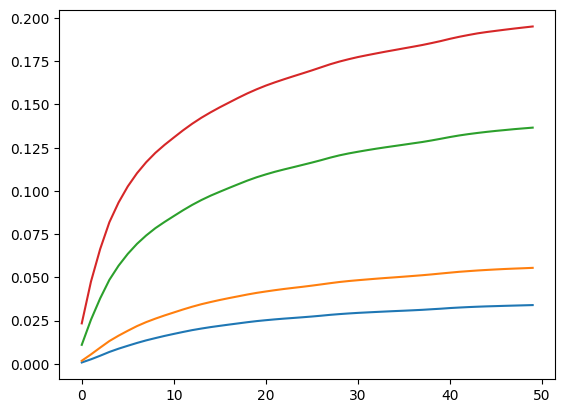

In [ ]:
%%time

model, history, metrics = compile_and_fit(model_retrival, cached_train, cached_test)

index = tfrs.layers.factorized_top_k.BruteForce(model.query_model, k = 100)

index.index_from_dataset(
    tf.data.Dataset.zip((product_ds.map(lambda x: x['product_id']).batch(128), product_ds.batch(128).map(model.candidate_model)))
)

score, title = index(buyer_info)

a = np.dstack((title, score))

print(a)

path = os.path.join('/content/drive/MyDrive/Work/C4R/Metro/Models', "UA_P2C_all_sku")

tf.saved_model.save(index, path)

loaded = tf.saved_model.load(path)
loaded(buyer_info)

plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_50_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_100_categorical_accuracy'])

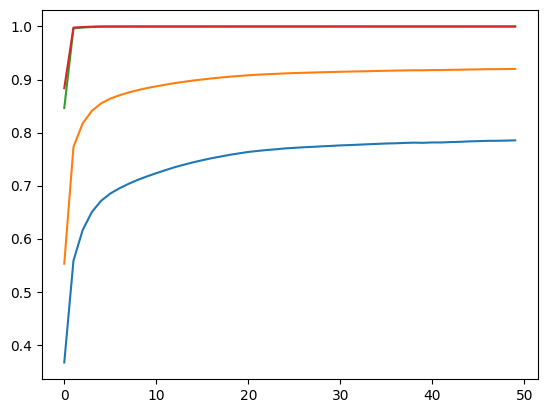

In [ ]:
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_50_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_100_categorical_accuracy'])

## Testing model

In [ ]:
path = '/content/drive/MyDrive/Work/C4R/Metro/Models/complex_input'

In [ ]:
loaded = tf.saved_model.load(path)

loaded

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x78784b127a90>

In [ ]:
buyer_info = {'customer_id': np.array([b'330067026301'], dtype='|S12'),
 'city': np.array([b'KYIV'], dtype='|S4'),
 'revenue': np.array([91389])}

buyer_info


{'customer_id': array([b'330067026301'], dtype='|S12'),
 'city': array([b'KYIV'], dtype='|S4'),
 'revenue': array([91389])}

In [ ]:
loaded(buyer_info)

(<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[0.75180477, 0.6714635 , 0.64938724, 0.6353227 , 0.62982535,
         0.61838734, 0.6164228 , 0.6163168 , 0.61302835, 0.6129947 ,
         0.606409  , 0.6040448 , 0.60399526, 0.60155344, 0.6009756 ,
         0.59922534, 0.5969476 , 0.5901873 , 0.5792782 , 0.5787154 ,
         0.5654048 , 0.5563152 , 0.5556531 , 0.5552453 , 0.5522891 ,
         0.5439477 , 0.5396591 , 0.5380825 , 0.53641725, 0.53561795,
         0.53386265, 0.530015  , 0.52978635, 0.52768767, 0.52640384,
         0.52634716, 0.5221656 , 0.5132313 , 0.5125191 , 0.51193976,
         0.51167566, 0.5095954 , 0.5093968 , 0.5092213 , 0.50875324,
         0.50825   , 0.5080611 , 0.5075394 , 0.5070076 , 0.50412965,
         0.503091  , 0.49973798, 0.49932605, 0.49662486, 0.49651015,
         0.49554792, 0.49505866, 0.4947426 , 0.4915099 , 0.49101853,
         0.49055272, 0.4900565 , 0.49002844, 0.48805982, 0.48669818,
         0.48659405, 0.48646048, 0.48639047, 0.48612

In [ ]:
# Create an iterator over the dataset
iterator = client_ds.shuffle(buffer_size=1000).take(1).as_numpy_iterator()

# Iterate over the elements and extract values
for elem in iterator:
    buyer_info = {
        'customer_id': np.array([elem['customer_id']]),
        # 'segment': np.array([elem['segment']]),
        'city': np.array([elem['city']]),
        # 'ts': np.array([elem['ts']]),
        # 'visits': np.array([elem['visits']]),
        'revenue': np.array([elem['revenue']]),
        # 'category': np.array([elem['category']]),
        # 'articul': np.array([elem['articul']]),
        # 'sub_category': np.array([elem['sub_category']])
    }
    extracted_id = np.array(elem['product_id']).astype(int)

# product_row = articles_df[articles_df['product_id'] == extracted_id]

# print(product_row[['art_name', 'pcg_cat_desc_tl', 'pcg_sub_cat_desc']])

print(buyer_info)


{'customer_id': array([b'330067027001'], dtype='|S12'), 'city': array([b'KYIV'], dtype='|S4'), 'revenue': array([61803])}


# Model Ranking

## Vocabs

In [ ]:
revenues = np.concatenate(list(client_ds.map(lambda x: x["revenue"]).batch(1_000)))
max_revenues = revenues.max()
min_revenues = revenues.min()

revenues_buckets = np.linspace(
    min_revenues, max_revenues, num=100,
)
unique_revenues = np.unique(np.concatenate(list(client_ds.batch(1_000).map(
                                                  lambda x: x['revenue']))))

print(len(unique_revenues))
print(unique_revenues[:10])


92452
[ 0  1  4  6  7  8  9 10 11 12]


In [ ]:
unique_product_ids = np.unique(np.concatenate(list(product_ds.batch(1_000).map(
    lambda x: x["product_id"]))))

print(len(unique_product_ids))
print(unique_product_ids[:10])


1026
[b'100007001001' b'100101001001' b'100301001001' b'100360001001'
 b'101960001001' b'102575001003' b'103058001001' b'107311001001'
 b'107649001001' b'107652001001']


In [ ]:
unique_customer_id = np.unique(np.concatenate(list(client_ds.batch(1_000).map(
    lambda x: x["customer_id"]))))

print(len(unique_customer_id))
print(unique_customer_id[:10])


367280
[b'100000002701' b'100000003802' b'100000004301' b'100000005401'
 b'100000008201' b'100000009201' b'100000013101' b'100000018101'
 b'100000019304' b'100000020501']


In [ ]:
unique_city = np.unique(np.concatenate(list(client_ds.batch(1_000).map(
    lambda x: x["city"]))))

print(len(unique_city))
print(unique_city)


17
[b'CHERNIGIV' b'CHERNIVTSI' b'DNIPROPETROVSK' b'IVANO-FRANKIVSK'
 b'KHARKIV' b'KRYVYY RIH' b'KYIV' b'LUTSK' b'LVIV' b'MYKOLAIV' b'ODESA'
 b'POLTAVA' b'RIVNE' b'TERNOPIL' b'VINNYTSYA' b'ZAPORIZHZHYA' b'ZHYTOMYR']


## Buyer Model

In [ ]:
class BuyerModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.customers_embedding = tf.keras.Sequential([
       tf.keras.layers.StringLookup(
         vocabulary = unique_customer_id, mask_token = None),
         tf.keras.layers.Embedding(len(unique_customer_id) + 1, 32),
     ])

    self.city_embedding = tf.keras.Sequential([
       tf.keras.layers.StringLookup(
         vocabulary = unique_city, mask_token = None),
         tf.keras.layers.Embedding(len(unique_city) + 1, 32),
     ])

    self.revenues_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(revenues_buckets.tolist()),
          tf.keras.layers.Embedding(len(revenues_buckets) + 1, 32),])
    self.normalized_revenues = tf.keras.layers.Normalization(axis=None)
    self.normalized_revenues.adapt(unique_revenues)

    # self.visits_embedding = tf.keras.Sequential([
    #       tf.keras.layers.Discretization(visits_buckets.tolist()),
    #       tf.keras.layers.Embedding(len(visits_buckets) + 1, 32),])
    # self.normalized_visits = tf.keras.layers.Normalization(axis=None)
    # self.normalized_visits.adapt(unique_visits)

  def call(self, inputs):
    return tf.concat([
      self.customers_embedding(inputs['customer_id']),
      self.city_embedding(inputs['city']),
      self.revenues_embedding(inputs["revenue"]),
      tf.reshape(self.normalized_revenues(inputs["revenue"]), (-1, 1)),
      # self.visits_embedding(inputs["visits"]),
      # tf.reshape(self.normalized_visits(inputs["visits"]), (-1, 1)),
      ], axis=1)


In [ ]:
buyer_model = BuyerModel()

for row in client_ds.batch(1).take(1):
  print(f"Computed representations: {buyer_model(row)[0, :]}")


Computed representations: [ 4.4537727e-02 -4.0564686e-04  4.3360796e-02  9.7468980e-03
  4.7466669e-02  3.3395853e-02 -1.2592532e-02 -1.7248333e-02
  6.1223134e-03  2.2165064e-02 -4.0997434e-02  8.9088567e-03
 -3.4294523e-02 -1.0235526e-02  2.0017747e-02 -3.7744164e-02
 -1.9615127e-02  3.3769097e-02  3.4217525e-02 -3.2142568e-02
 -3.9072145e-02 -3.3888318e-02  4.0603947e-02 -1.2986921e-02
  3.7648194e-03 -4.9586691e-02  3.6546174e-02  4.5401122e-02
  1.8443260e-02 -4.1353263e-02 -3.6225367e-02 -3.8377833e-02
 -2.3482120e-02  4.2262401e-02  2.1325555e-02  2.3772012e-02
  3.8285200e-02  4.7627855e-02 -1.3485599e-02  2.5991272e-02
  4.7355842e-02 -2.6074756e-02  3.7598778e-02 -1.8121876e-02
 -3.8631380e-02  3.4920607e-02 -1.7145537e-02 -3.3555675e-02
  4.7922943e-02  2.3781214e-02  1.3284627e-02 -2.4894476e-03
  4.5984499e-03  1.1398673e-02  3.9315950e-02 -2.1550918e-02
  2.0399664e-02 -3.7365332e-03 -2.9103518e-02 -2.4922550e-02
 -5.8839805e-03  2.6707638e-02 -3.0913508e-02  3.4682825e-0

## Product model

In [ ]:
class ProductModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.product_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_product_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_product_ids) + 1, 32),
    ])

  def call(self, inputs):
    return tf.concat([
      self.product_embedding(inputs['product_id'])
      ], axis=1)


In [ ]:
product_model = ProductModel()

for row in product_ds.batch(10).take(1):
    # print(row)
  print(f"Computed representations: {product_model(row)[0, :]}")


Computed representations: [-0.01461326 -0.04814415  0.003115   -0.01053192  0.04947645  0.01591602
  0.01186679 -0.04723597  0.01218813  0.01795491  0.04858079  0.0330842
  0.04217111 -0.01920893  0.0234175  -0.03146849  0.02236274  0.0004353
 -0.04113274  0.03965512  0.04565808  0.04628027 -0.03728383 -0.04167312
  0.00181194 -0.01436047 -0.04408305  0.02080217  0.0473468  -0.01340003
 -0.02648487 -0.0473168 ]


## Joint Model

In [ ]:
class Retrival_Ranking(tfrs.models.Model):

  def __init__(self):
    super().__init__()

    self.query_model = tf.keras.Sequential([
      BuyerModel(),
      tf.keras.layers.Dense(64, kernel_regularizer= tf.keras.regularizers.l1(0.01)),
      tf.keras.layers.Dense(32),
      tf.keras.layers.Dense(16),
             ])

    self.candidate_model = tf.keras.Sequential([
      ProductModel(),
      tf.keras.layers.Dense(64, kernel_regularizer= tf.keras.regularizers.l1(0.01)),
      tf.keras.layers.Dense(32),
      tf.keras.layers.Dense(16),
            ])

    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=product_ds.batch(128).map(self.candidate_model)
        )
        )

    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(1),
    ])

    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    buyer_embeddings = self.query_model({
      'customer_id': features['customer_id'],
      'city': features['city'],
      'revenue': features['revenue'],
            })

    product_embeddings = self.candidate_model({'product_id': features["product_id"]})

    return (buyer_embeddings,
            product_embeddings,
            self.rating_model(tf.concat([buyer_embeddings, product_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    ratings = features.pop("rating")
    buyer_embeddings, product_embeddings, rating_predictions = self(features)

    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )

    retrieval_loss = self.retrieval_task(buyer_embeddings, product_embeddings)

    return (retrieval_loss + rating_loss)


In [ ]:
model_retrival_ranking = Retrival_Ranking()


In [ ]:
iterator = client_ds.shuffle(buffer_size=1_000).take(1).as_numpy_iterator()

# Iterate over the elements and extract values
for elem in iterator:
    buyer_info = {
        'customer_id': np.array([elem['customer_id']]),
        'city': np.array([elem['city']]),
        # 'visits': np.array([elem['visits']]),
        'revenue': np.array([elem['revenue']]),
    }

print(model_retrival_ranking.query_model(buyer_info))

iterator = product_ds.shuffle(buffer_size=1_000).take(1).as_numpy_iterator()
for elem in iterator:
    product_detail = {
        'product_id': np.array([elem['product_id']])
    }

print(model_retrival_ranking.candidate_model(product_detail))


tf.Tensor(
[[-0.01047754  0.06008551  0.03777854  0.05487799 -0.10989873  0.03929884
   0.18259193 -0.01107749  0.1274728  -0.04818405 -0.00364708 -0.00065034
  -0.04981586 -0.09481703 -0.00803786  0.03017674]], shape=(1, 16), dtype=float32)
tf.Tensor(
[[-0.01040065  0.0017796  -0.00275109  0.07885028 -0.03707761  0.05750762
  -0.03895428  0.05963778 -0.00782866 -0.00150383  0.0074627  -0.06794725
  -0.04814696 -0.00984733  0.00818236 -0.05784443]], shape=(1, 16), dtype=float32)


## Training

In [ ]:
tf.random.set_seed(158)
shuffled = client_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(3_000_000)
test = shuffled.skip(3_000_000)

cached_train = train.batch(5_000).cache()
cached_test = test.batch(2_000).cache()


In [ ]:
MAX_EPOCHS = 200

def compile_and_fit(model, train_ds, test_ds, patience=3):
   #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='factorized_top_k/top_5_categorical_accuracy',
  #                                                   patience=patience,
  #                                                   mode='min')

  log_dir = "/content/drive/MyDrive/Work/C4R/Metro/logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
  # log_dir = "" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  model.compile(optimizer= tf.keras.optimizers.Adagrad(0.1))

  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      callbacks = [tensorboard_callback])
  metrics = model.evaluate(test_ds, return_dict=True)

  return model, history, metrics


In [ ]:
%%time

model, history, metrics = compile_and_fit(model_retrival_ranking, cached_train, cached_test)

index = tfrs.layers.factorized_top_k.BruteForce(model.query_model, k = 100)

index.index_from_dataset(
    tf.data.Dataset.zip((product_ds.map(lambda x: x['product_id']).batch(128), product_ds.batch(128).map(model.candidate_model)))
)

score, title = index(buyer_info)

a = np.dstack((title, score))

print(a)

path = os.path.join('/content/drive/MyDrive/Work/C4R/Metro/Models', "UA_1000_sku_retr_rank")

tf.saved_model.save(index, path)

loaded = tf.saved_model.load(path)
loaded(buyer_info)

Epoch 1/200


600/600 [==============================] - 138s 223ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0505 - factorized_top_k/top_5_categorical_accuracy: 0.0821 - factorized_top_k/top_10_categorical_accuracy: 0.0991 - factorized_top_k/top_50_categorical_accuracy: 0.1659 - factorized_top_k/top_100_categorical_accuracy: 0.2221 - root_mean_squared_error: 1057.6680 - loss: 1171060.2858 - regularization_loss: 11.5783 - total_loss: 1171071.8667
Epoch 2/200
600/600 [==============================] - 124s 207ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0354 - factorized_top_k/top_5_categorical_accuracy: 0.0560 - factorized_top_k/top_10_categorical_accuracy: 0.0684 - factorized_top_k/top_50_categorical_accuracy: 0.1312 - factorized_top_k/top_100_categorical_accuracy: 0.1900 - root_mean_squared_error: 1039.8765 - loss: 1125636.7326 - regularization_loss: 11.7225 - total_loss: 1125648.4581
Epoch 3/200
600/600 [==============================] - 125s 208ms/step - factorized_top_k/

162/162 [==============================] - 60s 115ms/step - factorized_top_k/top_1_categorical_accuracy: 5.8376e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0049 - factorized_top_k/top_10_categorical_accuracy: 0.0111 - factorized_top_k/top_50_categorical_accuracy: 0.0577 - factorized_top_k/top_100_categorical_accuracy: 0.1132 - root_mean_squared_error: 2036.4868 - loss: 4166193.6522 - regularization_loss: 20.3184 - total_loss: 4166214.0284


Cause: could not parse the source code of <function <lambda> at 0x7baace170940>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7baace170940>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[[[b'166881001001' 5.548588275909424]
  [b'348354001001' 5.4156670570373535]
  [b'183308001001' 5.399178504943848]
  [b'348356001001' 5.318217754364014]
  [b'100007001001' 5.305787086486816]
  [b'257800001001' 5.183775901794434]
  [b'157773001001' 5.098323822021484]
  [b'210684001001' 5.0428361892700195]
  [b'323173001001' 5.028331756591797]
  [b'371446001001' 4.884662628173828]
  [b'13395001001' 4.81324577331543]
  [b'251052001001' 4.7806172370910645]
  [b'251025001001' 4.768807888031006]
  [b'383086001001' 4.725900650024414]
  [b'230387001001' 4.7256388664245605]
  [b'164939001001' 4.67186164855957]
  [b'348721001001' 4.643793106079102]
  [b'157772001001' 4.572381496429443]
  [b'313518001001' 4.525941848754883]
  [b'212804001001' 4.419712066650391]
  [b'323172001001' 4.417242527008057]
  [b'300301001001' 4.410361289978027]
  [b'41180001001' 4.386767864227295]
  [b'201172001001' 4.380451679229736]
  [b'201173001001' 4.3506317138671875]
  [b'18846001001' 4.342782974243164]
  [b'3042110

CPU times: user 2d 4h 15min 50s, sys: 3h 12min 19s, total: 2d 7h 28min 10s
Wall time: 7h 27s


(<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[5.5485883, 5.415667 , 5.3991785, 5.3182178, 5.305787 , 5.183776 ,
         5.098324 , 5.042836 , 5.0283318, 4.8846626, 4.813246 , 4.780617 ,
         4.768808 , 4.7259007, 4.725639 , 4.6718616, 4.643793 , 4.5723815,
         4.525942 , 4.419712 , 4.4172425, 4.4103613, 4.386768 , 4.3804517,
         4.3506317, 4.342783 , 4.323124 , 4.302113 , 4.30155  , 4.298962 ,
         4.282564 , 4.273335 , 4.2481318, 4.233869 , 4.2275624, 4.2231884,
         4.2119565, 4.205803 , 4.181383 , 4.1671715, 4.114235 , 4.107917 ,
         4.1047707, 4.102819 , 4.0990314, 4.0835676, 4.0288725, 3.9934397,
         3.9883204, 3.9849925, 3.9548144, 3.8974488, 3.886759 , 3.8835268,
         3.8387015, 3.8340962, 3.792494 , 3.775229 , 3.7716212, 3.719751 ,
         3.7115517, 3.7045279, 3.6877773, 3.6773124, 3.6575353, 3.642109 ,
         3.5650191, 3.558156 , 3.553389 , 3.5385675, 3.527059 , 3.499076 ,
         3.4853878, 3.479145 , 3.4742172, 3.46738

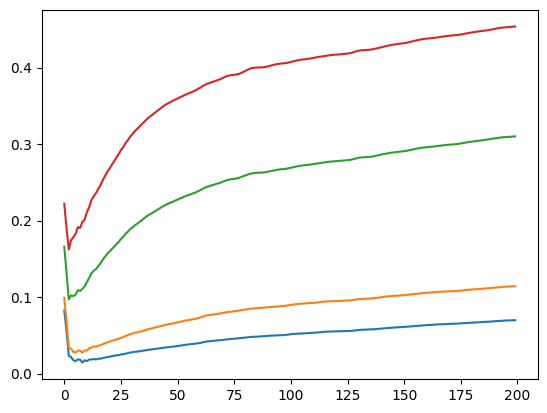

In [ ]:
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_10_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_50_categorical_accuracy'])
plt.plot(history.history['factorized_top_k/top_100_categorical_accuracy'])

## Testing model

In [ ]:
path = '/content/drive/MyDrive/Work/C4R/Metro/Models/complex_input'

In [ ]:
loaded = tf.saved_model.load(path)

loaded

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x78784b127a90>

In [ ]:
buyer_info = {'customer_id': np.array([b'330067026301'], dtype='|S12'),
 'city': np.array([b'KYIV'], dtype='|S4'),
 'revenue': np.array([91389])}

buyer_info


{'customer_id': array([b'330067026301'], dtype='|S12'),
 'city': array([b'KYIV'], dtype='|S4'),
 'revenue': array([91389])}

In [ ]:
loaded(buyer_info)

(<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[0.75180477, 0.6714635 , 0.64938724, 0.6353227 , 0.62982535,
         0.61838734, 0.6164228 , 0.6163168 , 0.61302835, 0.6129947 ,
         0.606409  , 0.6040448 , 0.60399526, 0.60155344, 0.6009756 ,
         0.59922534, 0.5969476 , 0.5901873 , 0.5792782 , 0.5787154 ,
         0.5654048 , 0.5563152 , 0.5556531 , 0.5552453 , 0.5522891 ,
         0.5439477 , 0.5396591 , 0.5380825 , 0.53641725, 0.53561795,
         0.53386265, 0.530015  , 0.52978635, 0.52768767, 0.52640384,
         0.52634716, 0.5221656 , 0.5132313 , 0.5125191 , 0.51193976,
         0.51167566, 0.5095954 , 0.5093968 , 0.5092213 , 0.50875324,
         0.50825   , 0.5080611 , 0.5075394 , 0.5070076 , 0.50412965,
         0.503091  , 0.49973798, 0.49932605, 0.49662486, 0.49651015,
         0.49554792, 0.49505866, 0.4947426 , 0.4915099 , 0.49101853,
         0.49055272, 0.4900565 , 0.49002844, 0.48805982, 0.48669818,
         0.48659405, 0.48646048, 0.48639047, 0.48612

In [ ]:
# Create an iterator over the dataset
iterator = client_ds.shuffle(buffer_size=1000).take(1).as_numpy_iterator()

# Iterate over the elements and extract values
for elem in iterator:
    buyer_info = {
        'customer_id': np.array([elem['customer_id']]),
        # 'segment': np.array([elem['segment']]),
        'city': np.array([elem['city']]),
        # 'ts': np.array([elem['ts']]),
        # 'visits': np.array([elem['visits']]),
        'revenue': np.array([elem['revenue']]),
        # 'category': np.array([elem['category']]),
        # 'articul': np.array([elem['articul']]),
        # 'sub_category': np.array([elem['sub_category']])
    }
    extracted_id = np.array(elem['product_id']).astype(int)

# product_row = articles_df[articles_df['product_id'] == extracted_id]

# print(product_row[['art_name', 'pcg_cat_desc_tl', 'pcg_sub_cat_desc']])

print(buyer_info)


{'customer_id': array([b'330067027001'], dtype='|S12'), 'city': array([b'KYIV'], dtype='|S4'), 'revenue': array([61803])}
